# Barotropic Streamfunction

The barotropic streamfunction ($\psi$) is obtained from the integration of the velocity field starting from a physical boundary at which we know the transport is zero. The difference between to streamlines is a measure of the transport between them. 

There are different ways to calculate it depending on your choice of boundary for the integration. This notebook calculates it integrating in the meridional space, starting from the Antarctic continent using the zonal velocity field:

$$
\psi = \int_{y_{\rm Antarctica}}^{y} U \, \mathrm{d}y ,
$$

where $U = \int u \, \mathrm{dz}$ is the depth-integrated $u$-velocity.

In [40]:
import numpy as np
import xarray as xr

import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

import dask.distributed as dask
import warnings
import intake
warnings.simplefilter(action = 'ignore', category = UserWarning)

Initialise a dask client

In [41]:
client = dask.Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46589/status,
Dashboard: /proxy/46589/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38291,Workers: 0
Dashboard: /proxy/46589/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40935,Total threads: 1
Dashboard: /proxy/44323/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:35041,


Load the ACCESS-NRI Intake Catalog

In [42]:
cat = intake.cat.access_nri
cat

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55_ryf_Control,{ACCESS-OM2-01},"{0.1° ACCESS-OM2 repeat year forcing control run for the simulations performed in Huguenin et al. (2024, GRL)}","{seaIce, ocean}","{1mon, fx}","{mlt_onset_m, vvel_m, average_T1, total_ocean_hflux_evap, u, total_volume_seawater, geolon_c, Tsfc_m, hi_m, mass_pmepr_on_nrho, uarea, ty_trans_nrho, blkmask, total_ocean_fprec, frazil_3d_int_z, t..."
01deg_jra55_ryf_ENFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 El Níño run for the simulations performed in Huguenin et al. (2024, GRL)}","{seaIce, ocean}","{1mon, fx}","{mlt_onset_m, vvel_m, average_T1, total_ocean_hflux_evap, u, total_volume_seawater, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, time, wt, area_u, sfc_hflux_from_run..."
01deg_jra55_ryf_LNFull,{ACCESS-OM2},"{0.1° ACCESS-OM2 La Níña run for the simulations performed in Huguenin et al. (2024, GRL)}","{seaIce, ocean}","{1mon, fx}","{mlt_onset_m, vvel_m, average_T1, total_ocean_hflux_evap, u, total_volume_seawater, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, time, wt, area_u, sfc_hflux_from_run..."
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1day, fx, 3mon, 3hr, 1mon}","{mlt_onset_m, wfimelt, vvel_m, average_T1, total_ocean_hflux_evap, u, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, surface_temp, time, pbot_t, fprec, wt, area_u, sfc..."
01deg_jra55v13_ryf9091_easterlies_down10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica decreased by 10%.},"{seaIce, ocean}","{1day, 1mon, fx}","{mlt_onset_m, wfimelt, vvel_m, average_T1, total_ocean_hflux_evap, u, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, surface_temp, time, pbot_t, fprec, wt, area_u, sfc..."
01deg_jra55v13_ryf9091_easterlies_up10,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal/meridional wind speed around Antarctica increased by 10%.},"{seaIce, ocean}","{1day, 1mon, fx}","{mlt_onset_m, wfimelt, vvel_m, average_T1, total_ocean_hflux_evap, u, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, surface_temp, time, pbot_t, fprec, wt, area_u, sfc..."
01deg_jra55v13_ryf9091_easterlies_up10_meridional,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and meridional wind speed around Antarctica increased by 10%.},"{seaIce, ocean}","{1day, 1mon, fx}","{mlt_onset_m, wfimelt, vvel_m, average_T1, total_ocean_hflux_evap, u, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, surface_temp, time, pbot_t, fprec, wt, area_u, sfc..."
01deg_jra55v13_ryf9091_easterlies_up10_zonal,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991) and zonal wind speed around Antarctica increased by 10%.},"{seaIce, ocean}","{1day, 1mon, fx}","{mlt_onset_m, wfimelt, vvel_m, average_T1, total_ocean_hflux_evap, u, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, surface_temp, time, pbot_t, fprec, wt, area_u, sfc..."
01deg_jra55v13_ryf9091_qian_wthmp,{ACCESS-OM2},"{Future perturbations with wind, thermal and meltwater forcing, branching off 01deg_jra55v13_ryf9091, as described in Li et al. 2023, https://www.nature.com/articles/s41586-023-05762-w}","{seaIce, ocean}","{1mon, fx}","{mlt_onset_m, wfimelt, vvel_m, average_T1, total_ocean_hflux_evap, u, geolon_c, Tsfc_m, hi_m, uarea, blkmask, total_ocean_fprec, frazil_3d_int_z, surface_temp, time, pbot_t, fprec, wt, area_u, sfc..."


The dictionary below specifies experiment, start and ending times for each model we can use (MOM5 or MOM6). 

If you want a different experiment, or a different time period, change the necessary values.

(We refer to the [tutorial](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Using_Explorer_tools.html) for more details on how to explore the available experiments and available output variables that exist in the cookbook database.)

In [43]:
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "data_var": "tx_trans_int_z",
                       "bathy_var" : "ht",
                       "start_date": "203[5-9].*|204[0-9].*",
                       "frequency" : "1mon",
            },

              "mom6": {"expt": "panant-01-zstar-v13",
                       "data_var": "umo_2d",
                       "bathy_var": "deptho",
                       "start_date": "203[5-9].*|204[0-9].*",
                       "frequency" : "1mon",
             }
}

# It shouldn't be necessary to use these, but we keep them around to show how to select a time range in xarray
start_time = "2035-01-01"
end_time =  "2050-01-01"

## Functions to load data

The functions below will load the necessary data, and calculate the barotropic streamfunction

In [44]:
def load_zonal_transport(model):
    """Load the zonal volume transport from ``model`` (either 'mom5' or 'mom6')."""

    # the reference density
    ρ0 = 1035 * ureg.kilogram / ureg.meter**3

    experiment = model_args[model]["expt"]
    start_date = model_args[model]["start_date"]
    var = model_args[model]["data_var"]
    freq = model_args[model]["frequency"]

    mass_transport = cat[experiment].search(
        variable=var, start_date=start_date,frequency=freq
    ).to_dask(xarray_open_kwargs={ "chunks" : { "time" : 3}, "decode_timedelta" : False }
    )[var] # Index into var to get a DataArray for the variable of interest from the dataset intake loads
    
    # ensure we get the time-slice we wanted
    mass_transport = mass_transport.sel(time = slice(start_time, end_time))
    
    # use pint to properly deal with units and unit conversions
    mass_transport = mass_transport.pint.quantify()
    
    volume_transport = mass_transport / ρ0
    volume_transport = volume_transport.pint.to('sverdrup') # convert units to Sv
    volume_transport.attrs['units'] = volume_transport.pint.units

    return volume_transport

def calculate_streamfunction(model):
    """Compute the streamfunction psi for ``model`` (either 'mom5' or 'mom6')."""

    volume_transport = load_zonal_transport(model)

    psi = volume_transport.cf.cumsum('latitude')
    
    psi = psi.rename('psi')
    psi.attrs['Standard name'] = 'Barotropic streamfunction'
    psi.attrs['units'] = psi.pint.units
    psi.pint.quantify()
    
    return psi

def get_land_mask(model):
    experiment = model_args[model]["expt"]
    var = model_args[model]["bathy_var"]
        
    bathymetry = cat[experiment].search(
        variable=var
    ).to_dask(xarray_open_kwargs={ "chunks" : { "time" : 3} }
    )[var] # Index into var to get a DataArray for the variable of interest from the dataset intake loads


    land_mask = xr.where(np.isnan(bathymetry), 1, np.nan)
    land_mask = land_mask.rename('land_mask')
    
    return land_mask

## Calculate the barotropic streamfunction and its time-mean

Now we compute the streamfunction using `calculate_streamfunction()`.

In [45]:
psi = {}
psi['mom5'] = calculate_streamfunction('mom5')
psi['mom6'] = calculate_streamfunction('mom6')

Calculate the time-mean of the streamfunction.

In [46]:
psi_mean = {}

psi_mean['mom5'] = psi['mom5'].cf.mean('time').load()
psi_mean['mom6'] = psi['mom6'].cf.mean('time').load()

2025-08-01 11:23:47,915 - distributed.protocol.pickle - ERROR - Failed to serialize <class 'pint.Quantity'>.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 60, in dumps
    result = pickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.PicklingError: Can't pickle <class 'pint.Quantity'>: it's not the same object as pint.Quantity

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 65, in dumps
    pickler.dump(x)
_pickle.PicklingError: Can't pickle <class 'pint.Quantity'>: it's not the same object as pint.Quantity

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/e

### Don't worry about these warnings!

## Let's plot

We define a nice plotting method using the model's land mask as land...

In [48]:
land_mask = {}
land_mask['mom5'] = get_land_mask('mom5')
land_mask['mom6'] = get_land_mask('mom6')

In [49]:
def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -40], crs = ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)

    return fig, ax

... and finally, it's time to visualise the streamfunction!

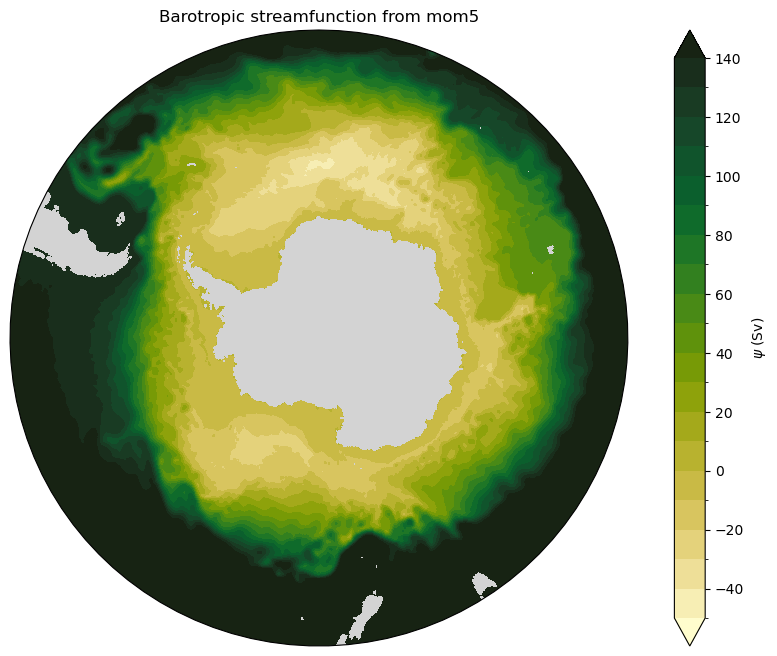

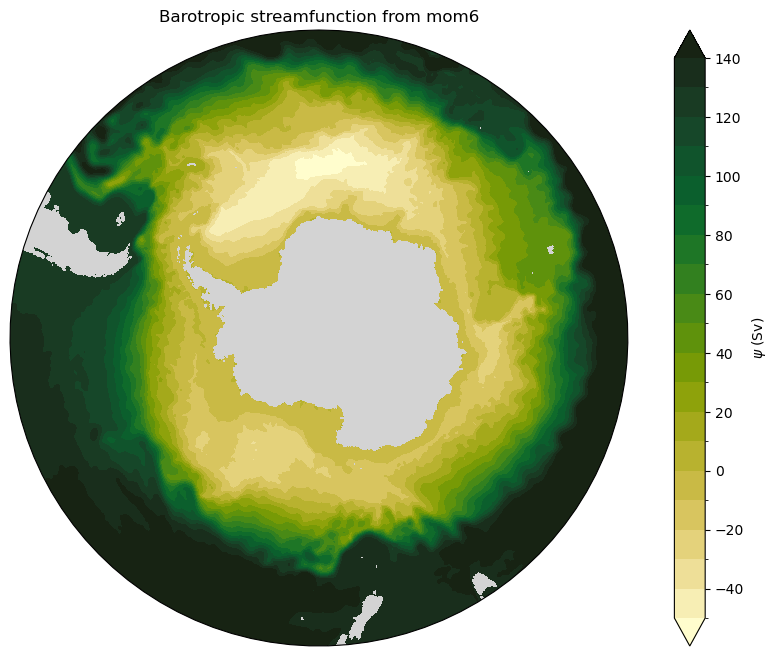

In [50]:
levels = np.arange(-50, 150, 10) # levels used in contour plots

for model in ['mom5', 'mom6']:

    fig, ax = circumpolar_map()

    psi_mean[model].cf.plot.contourf(ax = ax,
                                   x = 'longitude',
                                   y = 'latitude', 
                                   transform = ccrs.PlateCarree(),
                                   levels = levels,
                                   extend = 'both',
                                   cmap = cmocean.cm.speed,
                                   cbar_kwargs = {'label': '$\psi$ (Sv)'})
    land_mask[model].plot.contourf(ax = ax, colors = 'lightgrey', add_colorbar = False, 
                                   zorder = 2, transform = ccrs.PlateCarree())

    plt.title('Barotropic streamfunction from ' + model)